In [99]:
import open3d as o3d
import numpy as np
import os
import cv2
import re
import matplotlib.pyplot as plt

In [158]:
def compute_plane_normal_offset(pcd_file):
    pcd = o3d.io.read_point_cloud(pcd_file)
    # Assuming you have extracted planar points corresponding to the chessboard
    # Extract the points and compute the plane normal and offset using SVD
    points = np.asarray(pcd.points)
    centroid = np.mean(points, axis=0)
    points_centered = points - centroid
    U, _, V = np.linalg.svd(points_centered)
    normal = V[-1,:]  # Last column of U is the normal vector
    normal=normal/np.linalg.norm(normal)
    offset = -np.dot(normal, centroid)
    if offset<0:
        offset*=-1
        normal*=-1
    return normal, offset

In [159]:
i=0
nums=[]
image_files,pcd_files,cam_params=[],[],[]
for fname in (os.listdir("CV-A2-calibration/camera_images")):
    i+=1
    num=str(re.search(r'\d+', fname).group())
    nums.append(num)
    imgpath="CV-A2-calibration/camera_images/frame_"+num+".jpeg"
    image_files.append(imgpath)
    lidarpath="CV-A2-calibration/lidar_scans/frame_"+num+".pcd"
    pcd_files.append(lidarpath)
    params="CV-A2-calibration/camera_parameters/frame_"+num+".jpeg/"
    cam_params.append(params)
    if(i==25):
        break


In [160]:
l_normals=[]
l_alphas=[]
for i in pcd_files:
    normal, offset = compute_plane_normal_offset(i)
    l_normals.append(normal)
    l_alphas.append(offset)
c_normals=[]
rvecs=[]
tvecs=[]
cam_mats1=[]
for i in cam_params:
    file_path = i+"camera_normals.txt"
    with open(file_path, 'r') as file:
        lines = file.readlines()
    camera_normals_array = np.array([float(line.strip()) for line in lines])
    c_normals.append(camera_normals_array)
    file_path = i+"rotation_vectors.txt"
    with open(file_path, 'r') as file:
        lines = file.readlines()
    rot_vec = np.array([float(line.strip()) for line in lines])
    rvecs.append(rot_vec)
    file_path = i+"translation_vectors.txt"
    with open(file_path, 'r') as file:
        lines = file.readlines()
    tran_vec = np.array([float(line.strip()) for line in lines])
    tvecs.append(tran_vec)
    file_path = i+"rotation_matrix.txt"
    with open(file_path, 'r') as file:
        content = file.read()
    lines = content.strip().split('\n')
    values = [line.split() for line in lines]
    cam_mat1 = np.array(values, dtype=np.float32)
    cam_mats1.append(cam_mat1)
c_alphas=[]
for i in range(25):
    alpha_c = -np.dot(c_normals[i],tvecs[i])
    c_alphas.append(alpha_c)


In [161]:
file_path ="CV-A2-calibration/camera_parameters/camera_intrinsic.txt"
with open(file_path, 'r') as file:
    content = file.read()
lines = content.strip().split('\n')
values = [line.split() for line in lines]
cam_mat = np.array(values, dtype=np.float32)
file_path ="CV-A2-calibration/camera_parameters/distortion.txt"
with open(file_path, 'r') as file:
    content = file.read()
lines = content.strip().split('\n')
values = [line.split() for line in lines]
dist_vec = np.array(values, dtype=np.float32)
cam_mat=np.array(cam_mat)
dist_vec=np.array(dist_vec)

In [162]:
c_normals=np.array(c_normals)
l_normals=np.array(l_normals)
c_alphas=np.array(c_alphas)
l_alphas=np.array(l_alphas)

In [163]:
def translation(c_normals,c_alphas,l_alphas) :
    t = np.linalg.inv(np.dot(c_normals.T , c_normals))
    trans_mat = np.dot(np.dot(t,c_normals.T),(c_alphas-l_alphas))
    return trans_mat
trans_mat=translation(c_normals,c_alphas,l_alphas)

In [164]:
def rotation(l_normals,c_normals):
    t = l_normals.T @ c_normals
    U , _, V_t = np.linalg.svd(t)
    rot_mat = V_t.T @ U.T
    return U, V_t,rot_mat
rot_mat=rotation(l_normals,c_normals)[2]

In [165]:
def estimate_transformation(Rot,Tran):
    Tran=Tran.reshape(3,1)
    print(f"det(R1) = {np.linalg.det(Rot)}")
    ans=np.hstack((Rot,Tran))
    ans=np.vstack((ans, [0,0,0,1]))
    return ans

cTl=estimate_transformation(rot_mat,trans_mat)

det(R1) = 1.0000000000000002


In [166]:
def lidar_to_cam(l_pts, CtL):
    # l_pts = np.hstack((l_pts, np.ones((len(l_pts), 1))))
    # print("Shape of lidar_points_homogeneous:", l_pts.shape)
    # print("Shape of CtL:", CtL.shape)
    c_pts = np.dot(CtL, l_pts.T).T
    # print("Shape of camera_points_homogeneous:", c_pts.shape)
    camera_points = c_pts[:, :3] / c_pts[:, 3][:, None]
    return camera_points

In [167]:
def cam_to_img(c_pts, cam_mat, d):
    proj_pts, _ = cv2.projectPoints(c_pts, np.zeros((3,)), np.zeros((3,)), cam_mat, d)
    proj_pts = proj_pts.squeeze()
    return proj_pts

In [168]:
def draw_projected_points(image, projected_points):
    image_with_points = np.copy(image)
    projected_points_int = np.round(projected_points).astype(int)
    for point in projected_points_int:
        cv2.circle(image_with_points, tuple(point), radius=3, color=(0, 255, 0), thickness=-1)  # Green color, filled circle
    return image_with_points

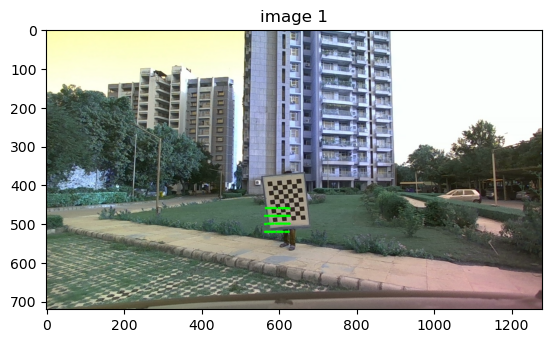

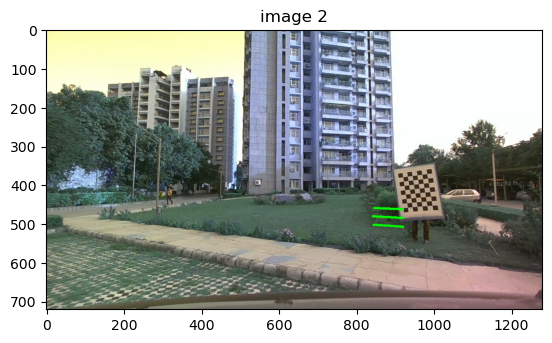

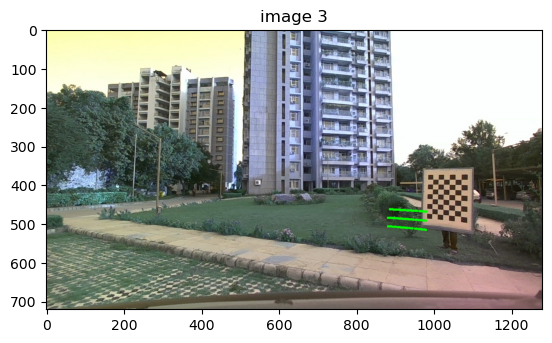

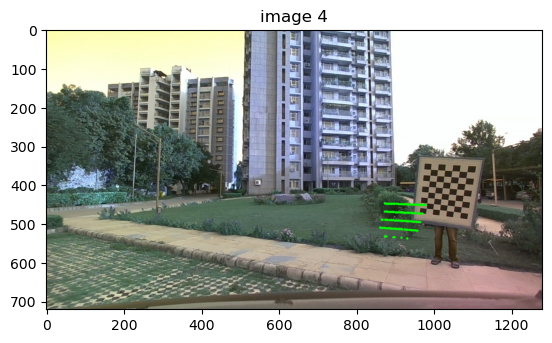

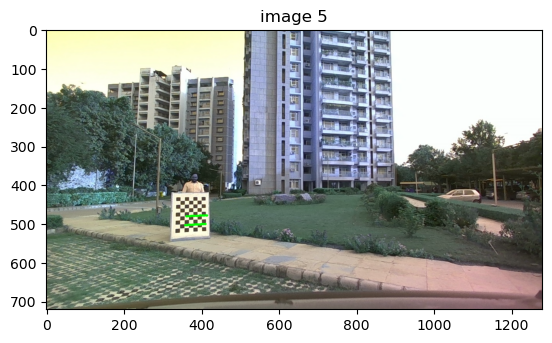

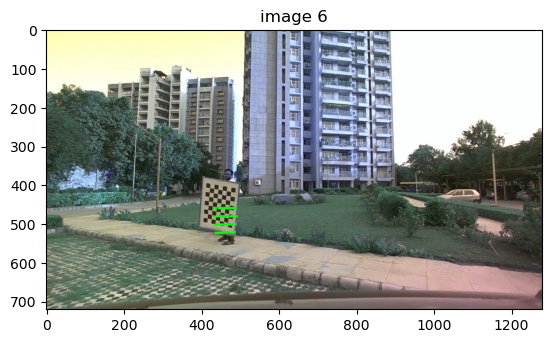

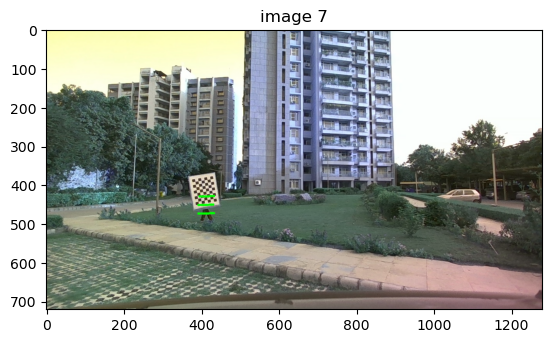

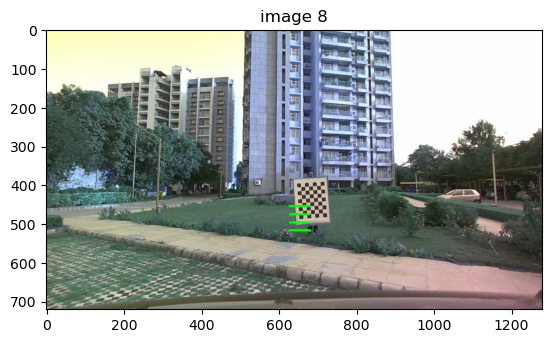

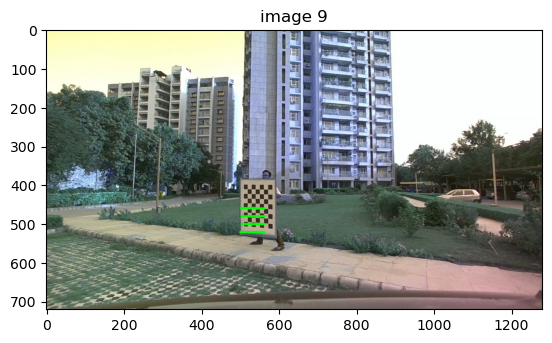

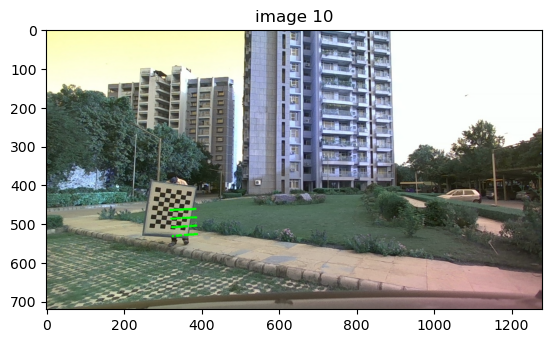

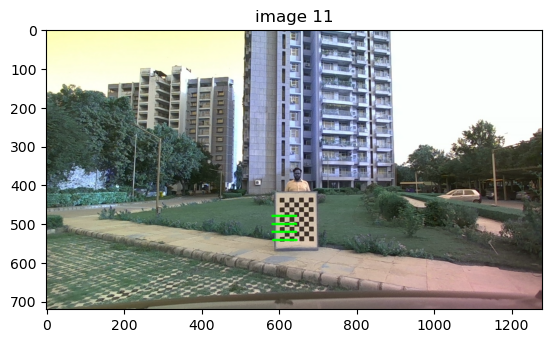

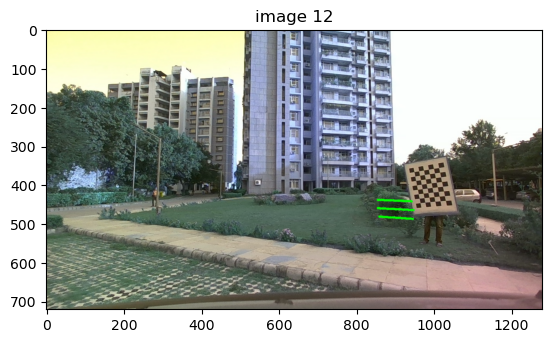

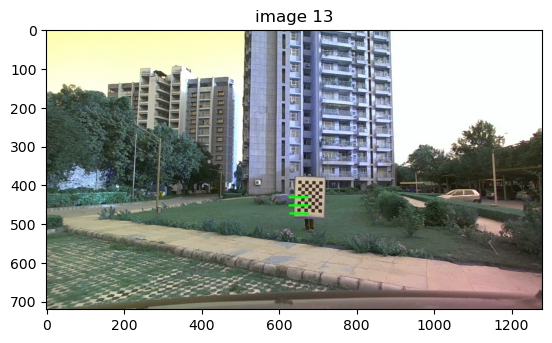

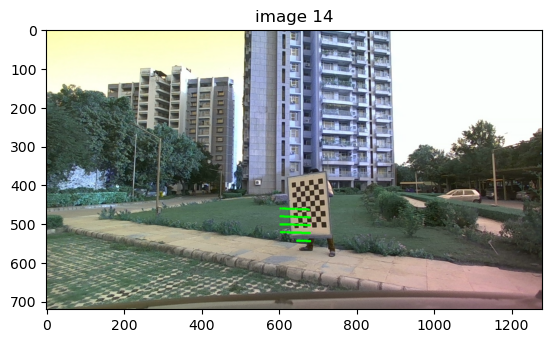

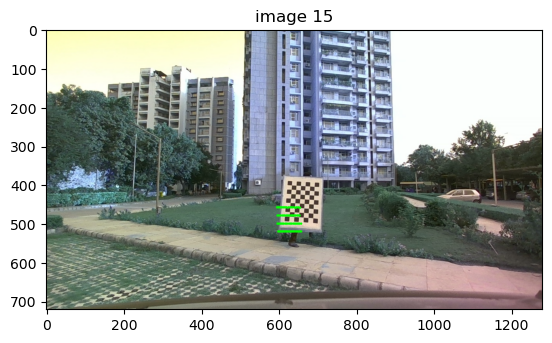

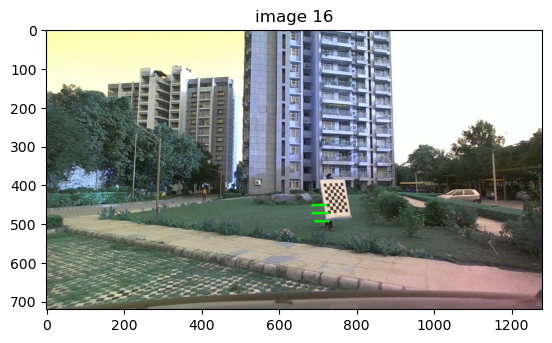

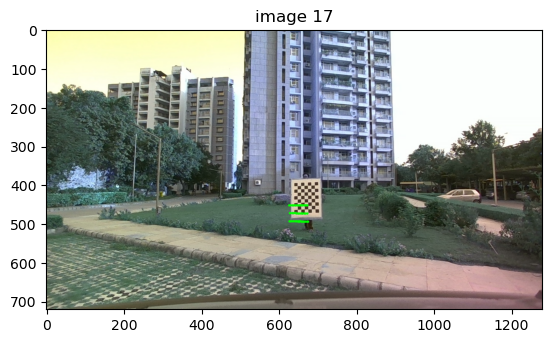

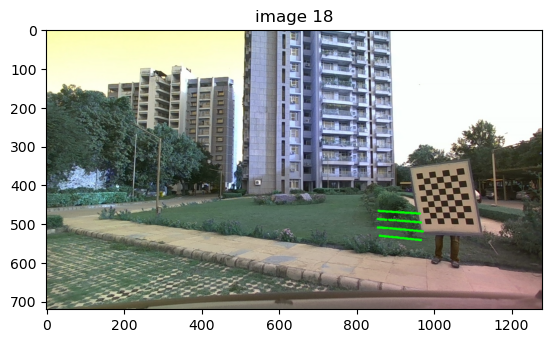

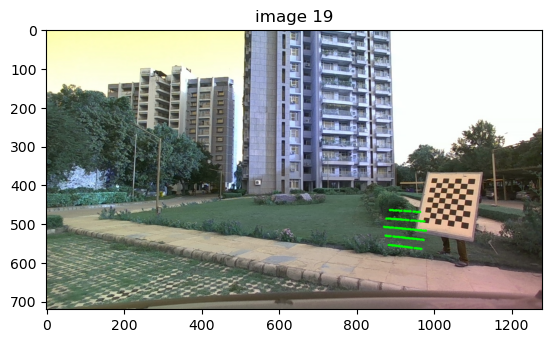

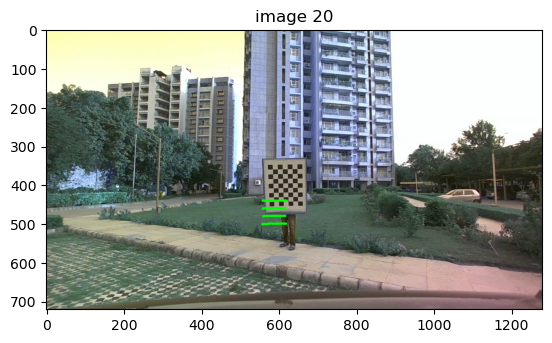

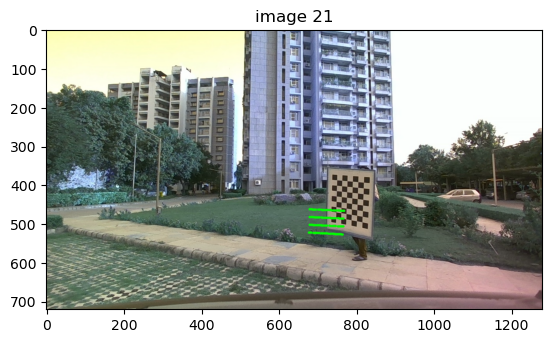

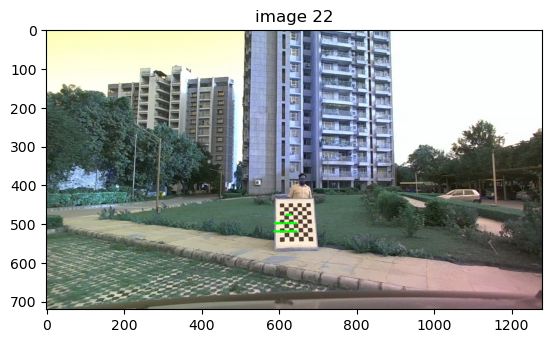

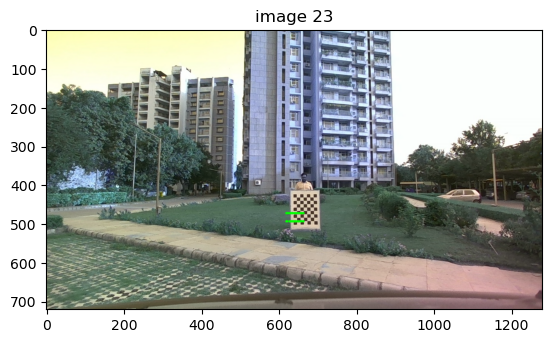

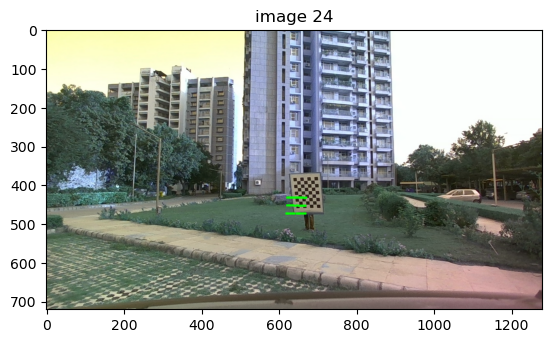

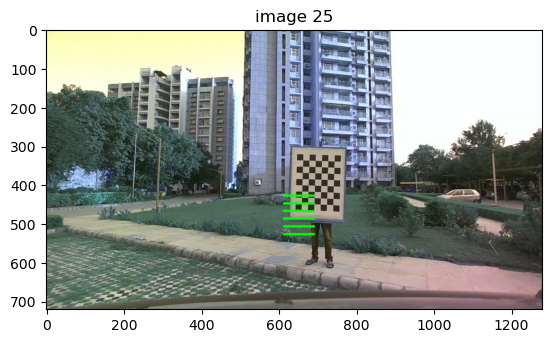

In [169]:
for i in range(25):
    pcd_path =pcd_files[i]
    img_path=image_files[i]
    point_cloud = o3d.io.read_point_cloud(pcd_path)
    lidar_points_xyz = np.asarray(point_cloud.points)
    lidar_pts_homogeneous = np.hstack((lidar_points_xyz, np.ones((lidar_points_xyz.shape[0], 1))))
    cam_pts=lidar_to_cam(lidar_pts_homogeneous,cTl)
    img_proj_pts=cam_to_img(cam_pts,cam_mat,dist_vec)
    img = cv2.imread(img_path)
    img_final=draw_projected_points(img,img_proj_pts)
    plt.title(f"image {i+1}")
    plt.imshow(img_final)
    plt.show()

Yes, all projected points  are in the boundary, else there will be an error, while plotting images, if it is out of boundary

In [173]:
i=0
nums=[]
image_files,pcd_files,cam_params=[],[],[]
for fname in (os.listdir("CV-A2-calibration/camera_images")):
    i+=1
    num=str(re.search(r'\d+', fname).group())
    nums.append(num)
    imgpath="CV-A2-calibration/camera_images/frame_"+num+".jpeg"
    image_files.append(imgpath)
    lidarpath="CV-A2-calibration/lidar_scans/frame_"+num+".pcd"
    pcd_files.append(lidarpath)
    params="CV-A2-calibration/camera_parameters/frame_"+num+".jpeg/"
    cam_params.append(params)

l_normals=[]
l_alphas=[]
for i in pcd_files:
    normal, offset = compute_plane_normal_offset(i)
    l_normals.append(normal)
    l_alphas.append(offset)
c_normals=[]
rvecs=[]
tvecs=[]
cam_mats1=[]
for i in cam_params:
    file_path = i+"camera_normals.txt"
    with open(file_path, 'r') as file:
        lines = file.readlines()
    camera_normals_array = np.array([float(line.strip()) for line in lines])
    c_normals.append(camera_normals_array)
    file_path = i+"rotation_vectors.txt"
    with open(file_path, 'r') as file:
        lines = file.readlines()
    rot_vec = np.array([float(line.strip()) for line in lines])
    rvecs.append(rot_vec)
    file_path = i+"translation_vectors.txt"
    with open(file_path, 'r') as file:
        lines = file.readlines()
    tran_vec = np.array([float(line.strip()) for line in lines])
    tvecs.append(tran_vec)
    file_path = i+"rotation_matrix.txt"
    with open(file_path, 'r') as file:
        content = file.read()
    lines = content.strip().split('\n')
    values = [line.split() for line in lines]
    cam_mat1 = np.array(values, dtype=np.float32)
    cam_mats1.append(cam_mat1)
c_alphas=[]
for i in range(25):
    alpha_c = -np.dot(c_normals[i],tvecs[i])
    c_alphas.append(alpha_c)


In [174]:
cos_distances=[]
def cos_sim(rotation_matrix, camera_normal, lidar_normal):
    lidar_normal_transformed = rotation_matrix @ lidar_normal.T
    dot_product = np.dot(camera_normal, lidar_normal_transformed)
    magnitude_camera_normal = np.linalg.norm(camera_normal)
    magnitude_lidar_normal_transformed = np.linalg.norm(lidar_normal_transformed)
    cosine_similarity = dot_product / (magnitude_camera_normal * magnitude_lidar_normal_transformed)
    return cosine_similarity

for i in range(len(l_normals)) :
    n_l = l_normals[i]
    n_c = c_normals[i] 
    cd = cos_sim(rot_mat,n_l,n_c)
    cos_distances.append(cd)

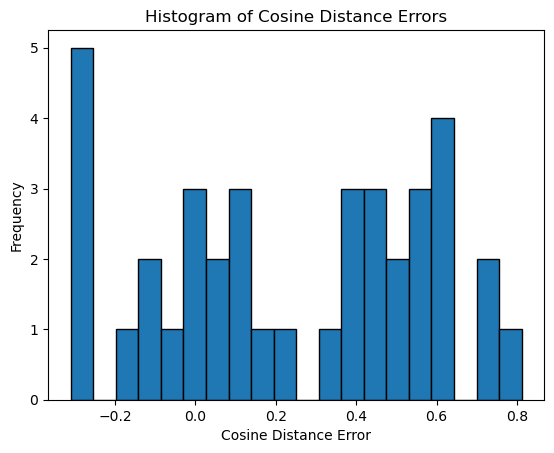

Average error: 0.24151999874027993
Standard deviation: 0.3357769959565255


In [182]:
plt.hist(cos_distances, bins=20, edgecolor='black')
plt.xlabel('Cosine Distance Error')
plt.ylabel('Frequency')
plt.title('Histogram of Cosine Distance Errors')
plt.show()

avg_error = np.mean(np.array(cos_distances))

standard_deviation = np.std(np.array(cos_distances))

print("Average error:", avg_error)
print("Standard deviation:", standard_deviation)

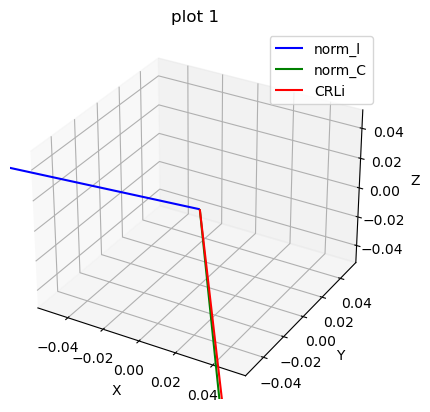

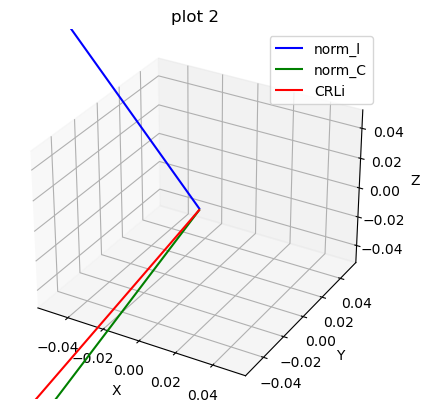

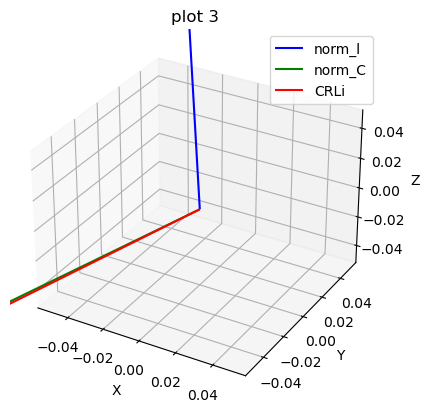

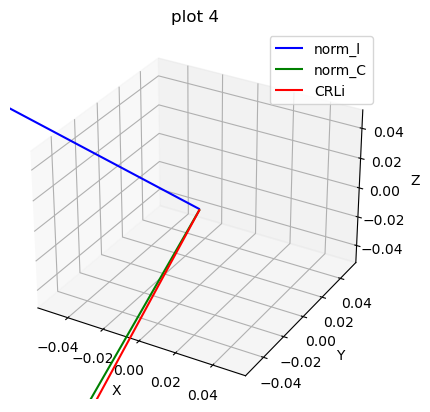

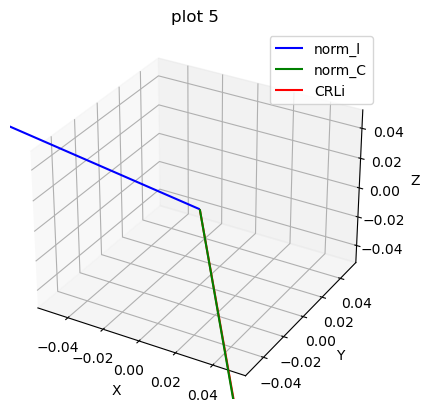

In [176]:
for i in range(5):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    norm_l = l_normals[i]
    ax.quiver(0, 0, 0, norm_l[0], norm_l[1], norm_l[2], color='b', label='norm_l')
    norm_c = c_normals[i]
    ax.quiver(0, 0, 0, norm_c[0], norm_c[1], norm_c[2], color='g', label='norm_C')
    n_li_transformed = rot_mat @ norm_l.T
    n_CRLi = n_li_transformed
    ax.quiver(0, 0, 0, n_CRLi[0], n_CRLi[1], n_CRLi[2], color='r', label='CRLi')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    ax.set_title(f"plot {i+1}")

# Show plot
plt.show()
